# OPeNDAP DAP Protocol



```{note}
**Why is it important to understand the data type covered by each protocol?** OPeNDAP servers that implement `DAP2` and `DAP4` are written in `C/C++` and `Java`, and which means PyDAP users MUST be aware of the atomic types that such servers are compatible with.
```

There are broadly `two DAP Data Models`: [DAP2](https://zenodo.org/records/10794666) and [DAP4](https://opendap.github.io/dap4-specification/DAP4.html). From the client perspective, these two have slight differences so we provide a brief overview of the two below 




The DAP4 data model is close to a _superset_ of the older DAP2 model except that `Grids` are no longer part of the DAP4 data model (see [Figure 1](Figure1)). However, since the `Grid` datatype is a DAP2 object (as opposed to a `netCDF/HDF` object), a _Grid object in DAP2 CAN be represented in DAP4_. This means that any dataset that is represented by the DAP2 data model (and say made available by a TDS/Hyrax server) can be fully represented in DAP4. However, DAP4 types and objects (like `Groups`, and `Int64`) served by a remote Hyrax/TDS data server cannot be represented in DAP2, and pydap will receive DAP responses missing those data types.

To learn more about the DAP4 specification, check the [DAP4 official documentation](https://opendap.github.io/dap4-specification/DAP4.html) written jointly by Unidata and OPeNDAP, Inc back in 2016.


| ![Figure1](/images/DAP4vsDAP2.png) | 
|:--:| 
| *Figure 1. Comparison between DAP2 and DAP4 data models and responses.* |


PyDAP aims at covering all of the DAP2 and DAP4 data models, broadly speaking, and so it covers the following DAP Objects:

* Groups
* Gridded Arrays.
* Sequences (Tabular data)
* Structures.

* All but `Opaque` and `Enum` atomic types (all others types can be represented by numpy array data).

When opening a remote URL `PyDAP` will create a `Dataset` object which acts like the `root` directly. `PyDAP`'s `Dataset` can then contain multiple data types, which may be `nested`. Since `PyDAP` approaches full support of the `DAP4` model, it supports `Groups` and nested `Groups`, which may themselves hold other data types, and other nested `PyDAP` objects named above.

## Groups

Groups are largely a feature of `HDF5/NetCDF4` file format models. Many remote datasets (e.g. from NASA made accessible by Hyrax data servers) may contain one or more `Groups`, some of them nested. Due to the complicate spec of the HDF data model, the `DAP4` specification follows closely the `netCDF4` model. This means there are no cyclic `Groups`. Instead, there is always a root, and each `Group` has a single parent `Group`.

To read data from a remote DAP4 server, you MUST set `open_url(..., protocol='dap4')`.


Consider the following example:




In [1]:
from pydap.client import open_url
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = open_url('http://test.opendap.org:8080/opendap/atlas03/ATL03_20181228015957_13810110_003_01.h5', protocol='dap4')
dataset

<DatasetType with children 'orbit_info', 'METADATA', 'gt1r', 'gt2r', 'gt1l', 'quality_assessment', 'atlas_impulse_response', 'gt3l', 'gt2l', 'ancillary_data', 'gt3r', 'ds_surf_type', 'ds_xyz'>

`print(dataset)` only returns the elements within the root directory. In `DAP4`, one can navigate the dataset as if it were a POSIX filesystem, and inspect the variables within a (nested) group. For example:

In [3]:
dataset['gt1r']

<GroupType with children 'bckgrd_atlas', 'geolocation', 'geophys_corr', 'signal_find_output', 'heights'>

In [4]:
dataset['/gt1r/bckgrd_atlas'].tree()

.bckgrd_atlas
├──delta_time
├──tlm_height_band1
├──bckgrd_rate
├──tlm_top_band1
├──tlm_top_band2
├──bckgrd_int_height_reduced
├──bckgrd_hist_top
├──bckgrd_counts_reduced
├──tlm_height_band2
├──bckgrd_int_height
├──pce_mframe_cnt
└──bckgrd_counts


We take a look at the variable `bckgrd_int_height` and its `dimensions`:

In [5]:
dataset['/gt1r/bckgrd_atlas/bckgrd_int_height'].attributes

{'contentType': 'modelResult',
 'coordinates': 'delta_time',
 'description': 'The height of the altimetric range window.  This is the height over which the 50-shot sum is generated.  Parameter is ingested at 50-Hz, and values are repeated to form a 200-Hz array.',
 'long_name': 'Altimetric range window width',
 'source': 'ATL03 ATBD Section 7.3',
 'units': 'meters',
 'path': '/gt1r/bckgrd_atlas',
 'dims': ['delta_time'],
 'Maps': ('/gt1r/bckgrd_atlas/delta_time',)}

In [6]:
dataset['/gt1r/bckgrd_atlas/bckgrd_int_height'].dimensions # dimensions of the variable

['/gt1r/bckgrd_atlas/delta_time']

In [7]:
dataset['/gt1r/bckgrd_atlas'].dimensions # Dimension of the Group

{'delta_time': 89490}

```{note}
The `dimension` `delta_time` is defined at the `Group` level, with a name relative to the (nested) `Group:/gt1r/bckgrd_atlas`. But when inspecting a variable array that list `delta_time` as its dimension, it lists `delta_time` with its Fully Qualifying Name (FQN)  
```

`Fully Qualifying Names` are an important feature of the DAP4 data model, avoiding name clashing across Groups. To read more about Qualifying Names, we refer you to the official [DAP4 Specification](https://opendap.github.io/dap4-specification/DAP4.html#_fully_qualified_names).



Attempting to read this dataset from a DAP4 server may result in an error

In [8]:
import requests
try:
    open_url('http://test.opendap.org:8080/opendap/atlas03/ATL03_20181228015957_13810110_003_01.h5', protocol='dap2')
except:
    print("Your request was for a response that uses the DAP2 data model. This dataset contains variables whose data type is not compatible with that data model, causing this request to FAIL. To access this dataset ask for the DAP4 binary response encoding.")

Your request was for a response that uses the DAP2 data model. This dataset contains variables whose data type is not compatible with that data model, causing this request to FAIL. To access this dataset ask for the DAP4 binary response encoding.


In the case above, a variable is of `Int64` (atomic) type, which causes the error. However, if instead the attribute is a type that is not supported by DAP2 model, the server will not raise an `HTTPError`, and `PyDAP` will download an `incomplete` dataset (with missing attributes)

## Arrays / Grids

Let\'s start by accessing `Gridded Array`, i.e., data that is stored as a regular multidimensional array. Here\'s a simple example where we access the [COADS](https://icoads.noaa.gov/) climatology from the official `OPeNDAP test server`:



In [9]:
dataset = open_url('http://test.opendap.org/dap/data/nc/coads_climatology.nc', protocol='dap4') # dap2 is the default
dataset

<DatasetType with children 'COADSX', 'COADSY', 'TIME', 'SST', 'AIRT', 'UWND', 'VWND'>

Here we used the `pydap.client.open_url` function to open an `OPeNDAP` URL specifying the location of the dataset. When we access the remote
dataset the function returns a `DatasetType` object, which is a fancy dictionary that stores other variables. We can
check the names of the store variables like we would do with a Python dictionary:


Another useful way to inspect the dataset is the `.tree()` method, which provides an in-depth inspection of your dataset

In [10]:
dataset.tree()

.coads_climatology.nc
├──COADSX
├──COADSY
├──TIME
├──SST
├──AIRT
├──UWND
└──VWND


```{note}
No data has been downloaded yet. 
```

Let\'s work with the `SST` variable; we can \"lazily\" reference it using the usual dictionary syntax of `dataset['SST']`, or `dataset.SST`:

In [11]:
dataset['/SST'].attributes

{'missing_value': -9.99999979e+33,
 '_FillValue': -9.99999979e+33,
 'long_name': 'SEA SURFACE TEMPERATURE',
 'history': 'From coads_climatology',
 'units': 'Deg C',
 'dims': ['TIME', 'COADSY', 'COADSX'],
 'Maps': ('/TIME', '/COADSY', '/COADSX')}

In [12]:
dataset['/SST'].dimensions

['/TIME', '/COADSY', '/COADSX']

In [13]:
%%time
sst = dataset['SST'][0, 45:80, 45:125]
print('Type of object: ', type(sst))

Type of object:  <class 'pydap.model.BaseType'>
CPU times: user 3.84 ms, sys: 1.6 ms, total: 5.45 ms
Wall time: 189 ms


###  old `DAP2` approach

Below, we access the same dataset on the same server and request the DAP2 response. 


In [14]:
dataset = open_url('http://test.opendap.org/dap/data/nc/coads_climatology.nc', output_grid=True) # dap2 is the default
dataset

/Users/jimenezm/miniforge3/envs/pydap_docs/lib/python3.11/site-packages/pydap/handlers/dap.py:135: UserWarning: PyDAP was unable to determine the DAP protocol defaulting to DAP2. DAP2 is consider legacy and may result in slower responses. 
Consider replacing `http` in your `url` with either `dap2` or `dap4` to specify the DAP protocol (e.g. `dap2://<data_url>` or `dap4://<data_url>`).  For more 
information, go to https://www.opendap.org/faq-page.
  _warnings.warn(


<DatasetType with children 'COADSX', 'COADSY', 'TIME', 'SST', 'AIRT', 'UWND', 'VWND'>

In [15]:
dataset.tree()

.coads_climatology.nc
├──COADSX
├──COADSY
├──TIME
├──SST
│  ├──SST
│  ├──TIME
│  ├──COADSY
│  └──COADSX
├──AIRT
│  ├──AIRT
│  ├──TIME
│  ├──COADSY
│  └──COADSX
├──UWND
│  ├──UWND
│  ├──TIME
│  ├──COADSY
│  └──COADSX
└──VWND
   ├──VWND
   ├──TIME
   ├──COADSY
   └──COADSX


In [16]:
sst = dataset['SST'] # or dataset.SST
sst

<GridType with array 'SST' and maps 'TIME', 'COADSY', 'COADSX'>

Note that the variable is of type `GridType`, a multidimensional array with specific axes defining each of its dimensions:

In [17]:
sst.dimensions

('TIME', 'COADSY', 'COADSX')

In [18]:
sst.shape

(12, 90, 180)

In [19]:
len(sst)

4

```{note}
`len` and `shape` of `sst` differ! The difference between them is a property of the `GridType`: in this case `sst` packs with itself the `coordinate axes` necessary to be fully "self-described". This behavior was done to mimick the `netCDF` model, that each file (in this case each `gridded array`) is "self-describing" and therefore contains all the relevant information to process it. The `tree` view of the dataset above further illustrates the point, with the multiple copies of coordinate data in dataset. Everytime you download a `GridType` you also download the dimension arrays used fully describe them. 

```


It is possible to specify NOT to download the coordinate axes of a `GridType` variable when opening a URL as follows:

In [20]:
dataset = open_url("http://test.opendap.org/dap/data/nc/coads_climatology.nc")
dataset

<DatasetType with children 'COADSX', 'COADSY', 'TIME', 'SST', 'AIRT', 'UWND', 'VWND'>

NO data has been downloaded into memory yet, but when you download a `GridType` array, the coordinate axes will not be downloaded. This important workaround is particularly usefull for speeding up workflows, and to not overwhelm older `OPeNDAP` servers that might run out of memory when attempting to retrieve both the data and the coordinate axes of a variable.


```{note}
The `GridType` is a `DAP2` model specification and was dropped in the much newer `DAP4`. Nonetheless, `OPeNDAP DAP4` servers support `DAP2`. Currently `PyDAP` when opening a remote URL, if `protocol` is not specified, `PyDAP` assumes by default the DAP2 model specification. This may change in the future.
```


In `PyDAP`, the `BaseType` is a thin wrapper to a `numpy.ndarray` with some of the same basic attributes like shape, nbytes. The `Dap4BaseProxy` is an empty data container with all the attributes of the remote array, including:

- `name`
- `dtype`
- `shape`
- `slice`



To `download` data into memory you must `slice` the array. This is:


In [21]:
%%time
sst = dataset['SST']['SST'][:]
print('Type of object: ', type(sst))

Type of object:  <class 'pydap.model.BaseType'>
CPU times: user 4.55 ms, sys: 7.39 ms, total: 11.9 ms
Wall time: 238 ms


In [22]:
type(sst.data)

numpy.ndarray

```{note}
One of the features of OPeNDAP is the `server-side subsetting`, which can be exploited by `PyDAP` via slicing of the array when downloading data. For example, if you are only interested in a localized subregion of the entire domain (e.g. finite range of latitude and longitudes of the global coverage), and you know the index that span your desired area of interest. 
```




In [23]:
%%time
sst = dataset['SST'][0, 45:80, 45:125]
print('Type of object: ', type(sst))

Type of object:  <class 'pydap.model.BaseType'>
CPU times: user 2.22 ms, sys: 1.01 ms, total: 3.23 ms
Wall time: 158 ms


In [24]:
sst.shape

(1, 35, 80)

```{note}
The subsetting took place close to the data thanks for OPenDAP's server functionality, and only the data that we request in the slice, is downloaded. 
```

```{note}
Slicing the array before downloading will almost always result in better performance and speed ups. This can be significant for very large datasets, and particularly useful when automatizing workflows that require downloading data into memory for further processing.

```

## Tabular data



Let's look now at tabular data, which `PyDAP` calls them `Sequences` (typically asociated with Sequential in situ data). Here we consider another file from within the test OPeNDAP server for simplicity. You can access the catalog [HERE](http://test.opendap.org/opendap/hyrax/).

```{note}
Sequential data consists of one of more records of related variables, such as simultaneous measurements of temperature and wind velocity for example. 
```



In [25]:
ds = open_url("http://test.opendap.org/opendap/hyrax/data/ff/gsodock1.dat")
ds.tree()

.gsodock1.dat
└──URI_GSO-Dock
   ├──Time
   ├──Depth
   ├──Sea_Temp
   ├──Salinity
   ├──DO%20
   ├──pH
   ├──Turbidity
   ├──Air_Temp
   ├──Wind_Speed
   ├──Wind_Direction
   └──Barometric_Pres


In [26]:
ds['URI_GSO-Dock']

<SequenceType with children 'Time', 'Depth', 'Sea_Temp', 'Salinity', 'DO%20', 'pH', 'Turbidity', 'Air_Temp', 'Wind_Speed', 'Wind_Direction', 'Barometric_Pres'>

### ERDDAP in situ data

Consider a more complex example. Here we look at data from the [glider](https://oceanservice.noaa.gov/facts/ocean-gliders.html) DAC found at the [Integrated Ocean Observing System](https://data.ioos.us/organization/glider-dac) . The data can be accessed through an OPeNDAP server, as well as the [ERRDAP](https://gliders.ioos.us/erddap/index.html) server. In the example below we demostrate how to access glider data from a
Deep-Pelagic Nekton study off the Gulf of Mexico, with pydap through `ERRDAP`.

We look at the `Dataset ID: Murphy-20150809T1355`. It's `ERDDAP` access form can be found [HERE](https://gliders.ioos.us/erddap/tabledap/Murphy-20150809T1355.html?trajectory%2Cwmo_id%2Cprofile_id%2Ctime%2Clatitude%2Clongitude%2Cdepth%2Cconductivity%2Cconductivity_qc%2Cdensity%2Cdensity_qc%2Cdepth_qc%2Cinstrument_ctd%2Clat_qc%2Clat_uv%2Clat_uv_qc%2Clon_qc%2Clon_uv%2Clon_uv_qc%2Cplatform_meta%2Cprecise_lat%2Cprecise_lon%2Cprecise_time%2Cpressure%2Cpressure_qc%2Cprofile_lat_qc%2Cprofile_lon_qc%2Cprofile_time_qc%2Cqartod_conductivity_flat_line_flag%2Cqartod_conductivity_gross_range_flag%2Cqartod_conductivity_primary_flag%2Cqartod_conductivity_rate_of_change_flag%2Cqartod_conductivity_spike_flag%2Cqartod_density_flat_line_flag%2Cqartod_density_gross_range_flag%2Cqartod_density_primary_flag%2Cqartod_density_rate_of_change_flag%2Cqartod_density_spike_flag%2Cqartod_monotonic_pressure_flag%2Cqartod_pressure_flat_line_flag%2Cqartod_pressure_gross_range_flag%2Cqartod_pressure_primary_flag%2Cqartod_pressure_rate_of_change_flag%2Cqartod_pressure_spike_flag%2Cqartod_salinity_flat_line_flag%2Cqartod_salinity_gross_range_flag%2Cqartod_salinity_primary_flag%2Cqartod_salinity_rate_of_change_flag%2Cqartod_salinity_spike_flag%2Cqartod_temperature_flat_line_flag%2Cqartod_temperature_gross_range_flag%2Cqartod_temperature_primary_flag%2Cqartod_temperature_rate_of_change_flag%2Cqartod_temperature_spike_flag%2Csalinity%2Csalinity_qc%2Ctemperature%2Ctemperature_qc%2Ctime_qc%2Ctime_uv%2Ctime_uv_qc%2Cu%2Cu_qc%2Cv%2Cv_qc&time%3E=2015-08-12T00%3A00%3A00Z&time%3C=2015-08-19T22%3A10%3A22Z)


In [27]:
ds = open_url("https://gliders.ioos.us/erddap/tabledap/Murphy-20150809T1355")['s']
ds.tree()

.s
├──trajectory
├──wmo_id
├──profile_id
├──time
├──latitude
├──longitude
├──depth
├──conductivity
├──conductivity_qc
├──density
├──density_qc
├──depth_qc
├──instrument_ctd
├──lat_qc
├──lat_uv
├──lat_uv_qc
├──lon_qc
├──lon_uv
├──lon_uv_qc
├──platform_meta
├──precise_lat
├──precise_lon
├──precise_time
├──pressure
├──pressure_qc
├──profile_lat_qc
├──profile_lon_qc
├──profile_time_qc
├──qartod_conductivity_flat_line_flag
├──qartod_conductivity_gross_range_flag
├──qartod_conductivity_primary_flag
├──qartod_conductivity_rate_of_change_flag
├──qartod_conductivity_spike_flag
├──qartod_density_flat_line_flag
├──qartod_density_gross_range_flag
├──qartod_density_primary_flag
├──qartod_density_rate_of_change_flag
├──qartod_density_spike_flag
├──qartod_location_test_flag
├──qartod_pressure_flat_line_flag
├──qartod_pressure_gross_range_flag
├──qartod_pressure_primary_flag
├──qartod_pressure_rate_of_change_flag
├──qartod_pressure_spike_flag
├──qartod_salinity_flat_line_flag
├──qartod_salinity_gross_

Where the variables `s` identifies the sequential data. 

In [28]:
type(ds)

pydap.model.SequenceType

We can further identify each individual glider data by looking at `profile_id`, a value that is unique for each of them. You can inspect the raw values are follows


In [29]:
[id for id in ds['profile_id'].iterdata()]

[np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7),
 np.int32(8),
 np.int32(9),
 np.int32(10),
 np.int32(11),
 np.int32(12),
 np.int32(13),
 np.int32(14),
 np.int32(15),
 np.int32(16),
 np.int32(17),
 np.int32(18),
 np.int32(19),
 np.int32(20),
 np.int32(21),
 np.int32(22),
 np.int32(23),
 np.int32(24),
 np.int32(25),
 np.int32(26),
 np.int32(27),
 np.int32(28),
 np.int32(29),
 np.int32(30),
 np.int32(31),
 np.int32(32),
 np.int32(33),
 np.int32(34),
 np.int32(35),
 np.int32(36),
 np.int32(37),
 np.int32(38),
 np.int32(39),
 np.int32(40),
 np.int32(41),
 np.int32(42),
 np.int32(43),
 np.int32(44),
 np.int32(45),
 np.int32(46),
 np.int32(47),
 np.int32(48),
 np.int32(49),
 np.int32(50),
 np.int32(51),
 np.int32(52),
 np.int32(53),
 np.int32(54),
 np.int32(55),
 np.int32(56),
 np.int32(57),
 np.int32(58),
 np.int32(59),
 np.int32(60),
 np.int32(61),
 np.int32(62),
 np.int32(63),
 np.int32(64),
 np.int32(65),
 np.int32(66),
 np.int32(67),
 np.

```{note}
`OPeNDAP` and therefore `PyDAP` support fully-qualifying names, which come in handly for complex (nested) data structures. In the case of `Sequential` data, you can access a variable `<VarName>` within a sequence named `<Seq>` as `<Seq.VarName>`
```

These datasets are rich in metadata, which can be accessed through the attributes property as follows


In [30]:
ds['profile_id'].attributes

{'_FillValue': -1,
 'actual_range': [1, 189],
 'cf_role': 'profile_id',
 'comment': 'Sequential profile number within the trajectory.  This value is unique in each file that is part of a single trajectory/deployment.',
 'ioos_category': 'Identifier',
 'long_name': 'Profile ID',
 'valid_max': 2147483647,
 'valid_min': 1}

The first thing we\'d like to do is limit our very simple analysis. We consider only a single glider and only inspect the variables `depth` and `temperature`. This is simlar to `column-wise selection`.


To accomplish that we use pydap\'s simple logic as follows


In [31]:
seq = ds[('profile_id', 'depth', 'temperature')]
print(type(seq))
seq.tree()

<class 'pydap.model.SequenceType'>
.s
├──profile_id
├──depth
└──temperature


### Filtering data

With `Sequential`  data we can make use of `filters` to extract only those values associated with one or more `rows`. This is, identify all the values of the sequence that are less than, equal to, or greater than. 

For example, lets consider `depth` and `temperature` values associated with the value `profile_id=5`.

In [32]:
glid5 = seq[('profile_id', 'depth', 'temperature')][seq['profile_id'].data==5]
glid5

<SequenceType with children 'profile_id', 'depth', 'temperature'>

In [33]:
Depths5 = np.array([depth for depth in glid5['depth']])
ids5 = np.array([_id for _id in glid5['profile_id']])
Temps5 = np.array([temp for temp in glid5['temperature']])

Lets try another `profile_id`.

In [34]:
glid6 = seq[('profile_id', 'depth', 'temperature')][seq['profile_id'].data==6]
Depths6 = np.array([depth for depth in glid6['depth']])
ids6 = np.array([_id for _id in glid6['profile_id']])
Temps6 = np.array([temp for temp in glid6['temperature']])

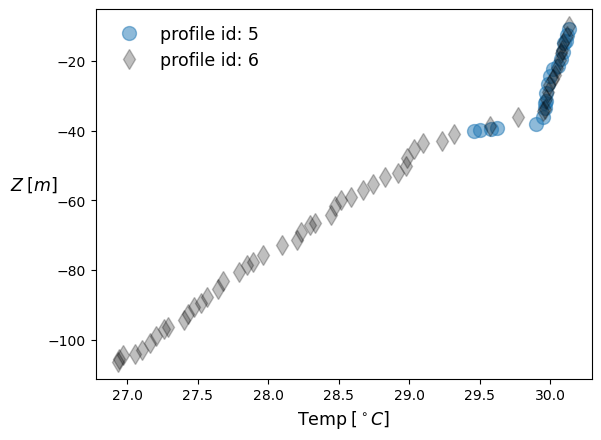

In [35]:
plt.plot(Temps5, -Depths5, ls='', marker='o', markersize=10, alpha=0.5, label='profile id: ' +str(ids5[0]))
plt.plot(Temps6, -Depths6, 'k', ls='', marker='d', markersize=10, alpha=0.25, label='profile id: ' +str(ids6[0]))
plt.xlabel(r'$\text{Temp} \;[^\circ C]$', fontsize=12.5)
plt.ylabel(r'$Z\;[m]$', fontsize=12.5, rotation=0, labelpad=10)
plt.legend(fontsize=12.5, frameon=False);

```{warning}
All Advanced features described below may be outdated.
```

### Advanced features

**Calling server-side functions**

When you open a remote dataset, the `DatasetType` object has a special
attribute named `functions` that can be used to invoke any server-side
functions. Here\'s an example of using the `geogrid` function from
Hyrax:

```{code}
>>> dataset = open_url("http://test.opendap.org/dap/data/nc/coads_climatology.nc")
>>> new_dataset = dataset.functions.geogrid(dataset.SST, 10, 20, -10,60)
>>> new_dataset.SST.COADSY[:] 
[-11. -9. -7. -5. -3. -1. 1. 3. 5. 7. 9. 11.]
>>> new_dataset.SST.COADSX[:]
[ 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61.]
```

Unfortunately, there\'s currently no standard mechanism to discover which functions the server support. The `function` attribute will accept
any function name the user specifies, and will try to pass the call to the remote server.



### Configuring a proxy
```{warning}
This may be outdated.
```
It\'s possible to configure pydap to access the network through a proxy
server. Here\'s an example for an HTTP proxy running on `localhost`
listening on port 8000:

```{code}
import httplib2
from pydap.util import socks
import pydap.lib
pydap.lib.PROXY = httplib2.ProxyInfo(
         socks.PROXY_TYPE_HTTP, 'localhost', 8000)
```

This way, all further calls to `pydap.client.open_url` will be routed through the proxy server. You can also authenticate to the proxy:

```{code}
pydap.lib.PROXY = httplib2.ProxyInfo(
         socks.PROXY_TYPE_HTTP, 'localhost', 8000,
         proxy_user=USERNAME, proxy_pass=PASSWORD)
```

A user [has reported](http://groups.google.com/group/pydap/browse_thread/thread/425b2e1a3b3f233d) that `httplib2` has problems authenticating against a NTLM proxy server. In this case, a simple solution is to change the `pydap.http.request` function to use `urllib2` instead of `httplib2`, monkeypatching the code
like in the [CAS authentication example above](#cas):

```{code}
import urllib2
import logging

def install_urllib2_client():
    def new_request(url):
        log = logging.getLogger('pydap')
        log.INFO('Opening %s' % url)

        f = urllib2.urlopen(url.rstrip('?&'))
        headers = dict(f.info().items())
        body = f.read()
        return headers, body

    from pydap.util import http
    http.request = new_request
```

The function `install_urllib2_client` should then be called before doing any requests.
